In [812]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [883]:
filepath = "../COVID Healthy diet dataset/Fat_Supply_Quantity_Data.csv"

df = pd.read_csv(filepath)

In [884]:
df.describe()

Alcoholic Beverages  Animal Products  Animal fats  \
count           170.000000       170.000000   170.000000   
mean              0.001035        20.695714     4.138451   
std               0.009569         8.002713     3.287462   
min               0.000000         5.018200     0.026200   
25%               0.000000        14.885800     1.674225   
50%               0.000000        20.943050     3.312350   
75%               0.000000        26.866950     6.227575   
max               0.097600        36.901800    14.937300   

       Aquatic Products, Other  Cereals - Excluding Beer        Eggs  \
count               170.000000                170.000000  170.000000   
mean                  0.000450                  4.376548    0.953890   
std                   0.004039                  3.183815    0.643957   
min                   0.000000                  0.990800    0.058000   
25%                   0.000000                  1.970150    0.411350   
50%                   0.000000                  3.306750    0.898300   
75%                   0.000000                  5.587600    1.276900   
max                   0.051100                 18.376300    3.275600   

       Fish, Seafood  Fruits - Excluding Wine        Meat  Miscellaneous  ...  \
count     170.000000               170.000000  170.000000     170.000000  ...   
mean        0.850437                 0.542117    9.494279       0.056589  ...   
std         0.924103                 0.838286    4.666762       0.072633  ...   
min         0.017400                 0.037300    0.906100       0.000000  ...   
25%         0.330975                 0.239500    6.263575       0.010125  ...   
50%         0.572700                 0.361400    9.259000       0.031650  ...   
75%         1.111625                 0.577800   11.750450       0.076325  ...   
max         8.406800                 9.672700   26.429200       0.456100  ...   

         Treenuts  Vegetal Products  Vegetable Oils  Vegetables     Obesity  \
count  170.000000        170.000000      170.000000  170.000000  167.000000   
mean     0.698955         29.304396       18.571657    0.309512   18.707784   
std      0.814828          8.002369        6.766615    0.211766    9.633557   
min      0.000000         13.098200        4.954900    0.026300    2.100000   
25%      0.137350         23.133050       13.812825    0.173675    8.500000   
50%      0.452400         29.060600       18.192550    0.247450   21.200000   
75%      0.914025         35.117250       23.597300    0.362925   25.700000   
max      4.975600         44.981800       36.418600    1.153800   45.600000   

         Population   Confirmed      Deaths   Recovered      Active  
count  1.700000e+02  162.000000  162.000000  162.000000  159.000000  
mean   4.452364e+07    0.612826    0.014382    0.421544    0.170407  
std    1.564182e+08    0.731432    0.020971    0.585557    0.291275  
min    5.400000e+04    0.000318    0.000000    0.000000    0.000000  
25%    2.816250e+06    0.072914    0.001141    0.039945    0.005022  
50%    1.018150e+07    0.361892    0.005132    0.166687    0.041464  
75%    3.271625e+07    0.918560    0.016602    0.537198    0.225449  
max    1.402385e+09    3.308116    0.102849    3.020768    1.726644  

[8 rows x 29 columns]

Setting the 'Country' column as the index.

In [885]:
df.set_index("Country", inplace=True)

Removing unnecessary column (only contains information about the unit of rest of the columns)

In [886]:
to_drop = ["Unit (all except Population)"]
df.drop(columns=to_drop, inplace=True, axis=1)

Converting 'string' type columns to numeric datatype. 

Dataset contains any percentage below 2.5% denotes as '<2.5'. Converting those values to 2.0 just as a crude way to handle the issue.

In [887]:
df['Undernourished'] = df['Undernourished'].replace('<2.5', 2.0)

In [888]:
df['Undernourished'] = pd.to_numeric(df['Undernourished'])

Ensuring all the columns are numeric

In [889]:
df.dtypes.value_counts()

float64    30
dtype: int64

Vizualizing the data with a heatmap to see where the missing values lie, we ca see that -

Other than features such as Obesity and Undernourished %, there are columns that will serve as label data which is missing ( COVID Confirmed, Deatth, Recovered, Active cases). These rows would be useless, since the feature data will give no insight on the COVID stats).

We will drop these rows.

<AxesSubplot:ylabel='Country'>

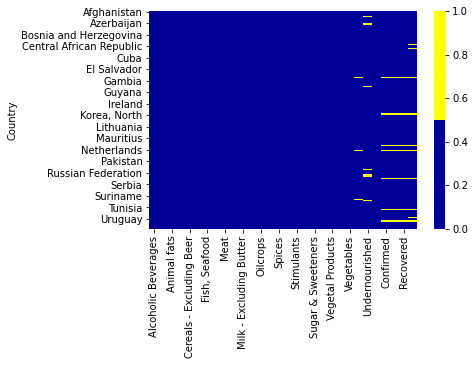

In [890]:
import seaborn as sns
cols = df.columns
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

In [891]:
df = df[df['Confirmed'].notna()]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

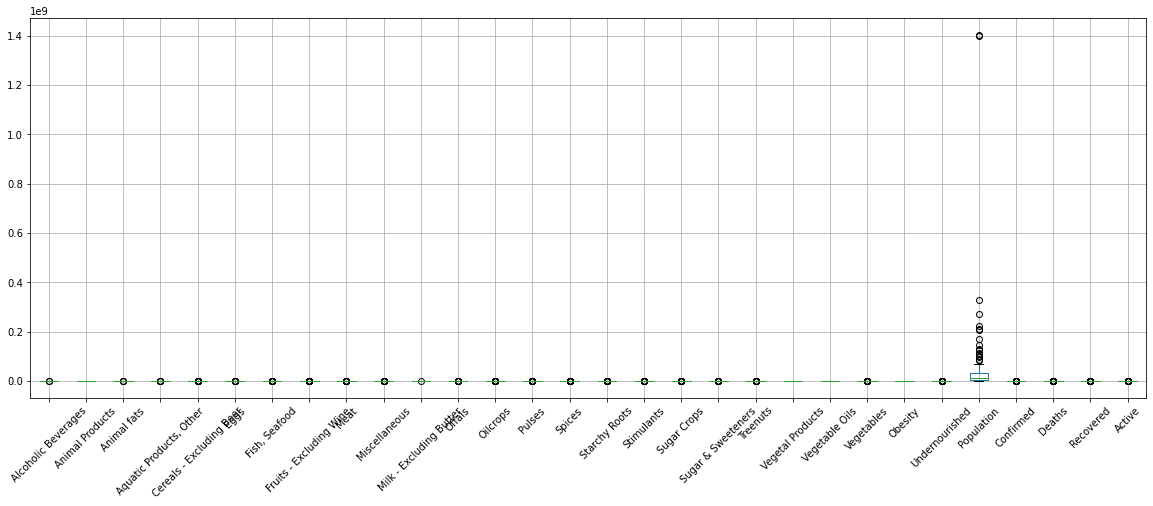

In [892]:
plt.figure(figsize = (20,7))
ax = df.boxplot()
plt.setp(ax.get_xticklabels(), rotation=45)

The population features ranges from 10^4 to 10^9. Scaling the population to 10 millions (to remove bias due to very high values) 

In [893]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['Population'] = scaler.fit_transform(np.array(df['Population']).reshape(-1,1))

Now, for the remaining missing values, we will use KNN algorithm to impute the missing values.

We use sklearn to achieve this.

In [894]:
imputer = KNNImputer(missing_values=np.nan, n_neighbors=5)
df[:] = imputer.fit_transform(df)

Checking whether algorithm can successfully and that all the missing values are removed.

In [895]:
df.isnull().values.any()

False

Now that we have cleaned the data, let's visualize the dataset to see if there are some outliers.

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

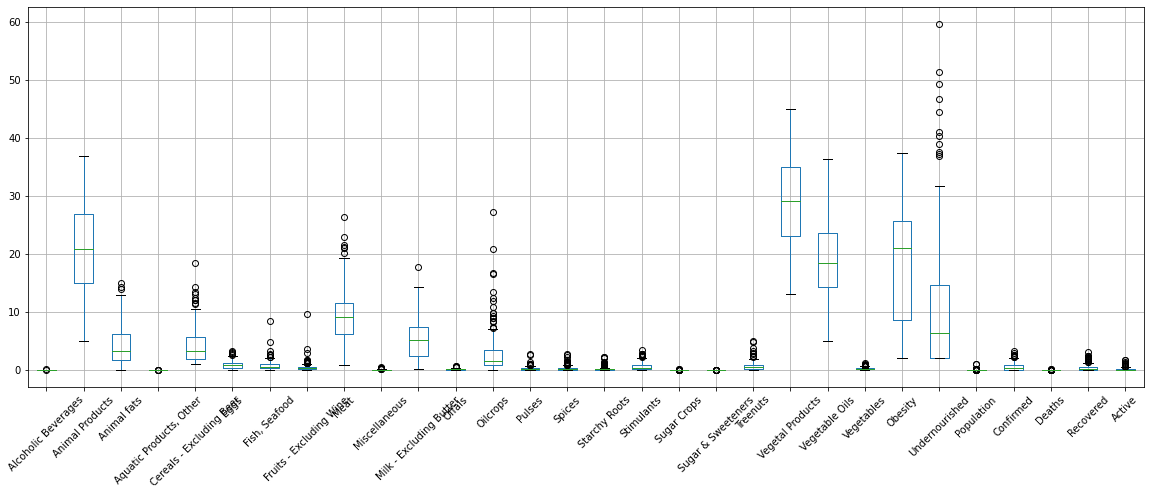

In [896]:
plt.figure(figsize = (20,7))
ax = df.boxplot()
plt.setp(ax.get_xticklabels(), rotation=45)

We can see that there is an outlier in the population column, so let's plot this feature separately.

Defining the features and labels.

In [897]:
# Separating out the features
features = ['Alcoholic Beverages',
 'Animal Products',
 'Animal fats',
 'Aquatic Products, Other',
 'Cereals - Excluding Beer',
 'Eggs',
 'Fish, Seafood',
 'Fruits - Excluding Wine',
 'Meat',
 'Miscellaneous',
 'Milk - Excluding Butter',
 'Offals',
 'Oilcrops',
 'Pulses',
 'Spices',
 'Starchy Roots',
 'Stimulants',
 'Sugar Crops',
 'Sugar & Sweeteners',
 'Treenuts',
 'Vegetal Products',
 'Vegetable Oils',
 'Vegetables',
 'Obesity',
 'Undernourished',
 'Population',
]

l1 = ['Confirmed']

# Separating the features
x = df.loc[:, features]

# Separating the target
y1 = df.loc[:,l1]

In [898]:
# Standardizing the features
x = StandardScaler().fit_transform(x)
x = pd.DataFrame(x, index=df.index, columns=features)

<AxesSubplot:ylabel='Country'>

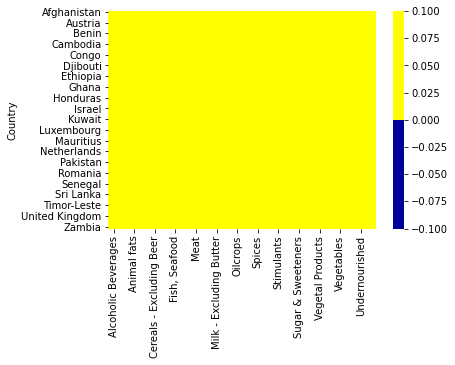

In [899]:
import seaborn as sns
cols = x.columns
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(x[cols].isnull(), cmap=sns.color_palette(colours))

<AxesSubplot:>

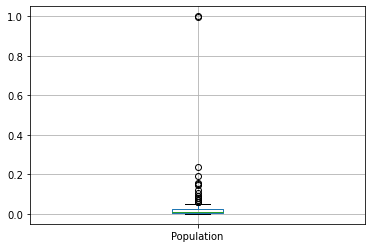

In [900]:
df.boxplot(column='Population')

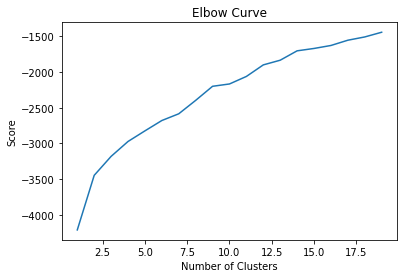

In [901]:
from scipy.spatial.distance import cdist

Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(x).score(x) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [902]:
corr = df.corr()

<AxesSubplot:>

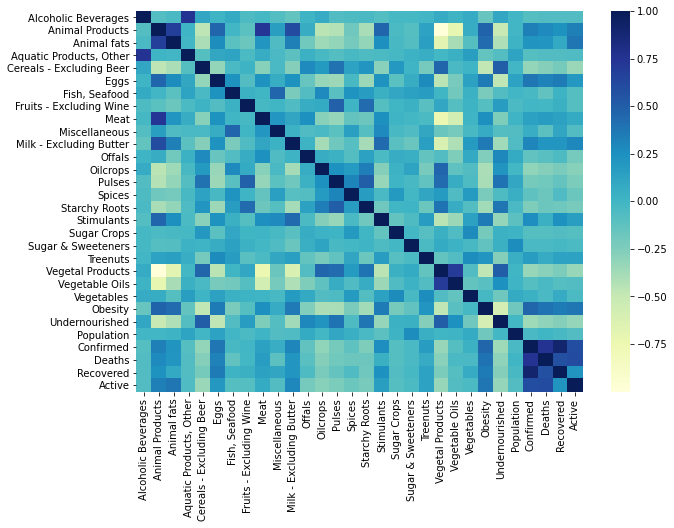

In [903]:
plt.figure(figsize = (10,7))
sns.heatmap(corr, cmap="YlGnBu")

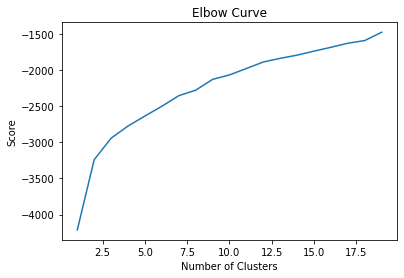

In [882]:
from scipy.spatial.distance import cdist

Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(x).score(x) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [856]:
x.shape[1]

26

In [857]:
from sklearn.decomposition import PCA
pca = PCA(n_components=26)
principalComponents = pca.fit_transform(x)
# principalDf = pd.DataFrame(data = principalComponents
#              , columns = ['principal component 1', 'principal component 2'])

In [858]:
explained_variance = pca.explained_variance_ratio_

In [859]:
num_principal_components = 0
cum_exp_var = 0
cumulative_var = []
for i in range(len(explained_variance)):
    cum_exp_var += explained_variance[i]
    cumulative_var.append(explained_variance[i])
    if(cum_exp_var>= 0.99):
        num_principal_components = i+1
        break

In [860]:
num_principal_components

22

<AxesSubplot:>

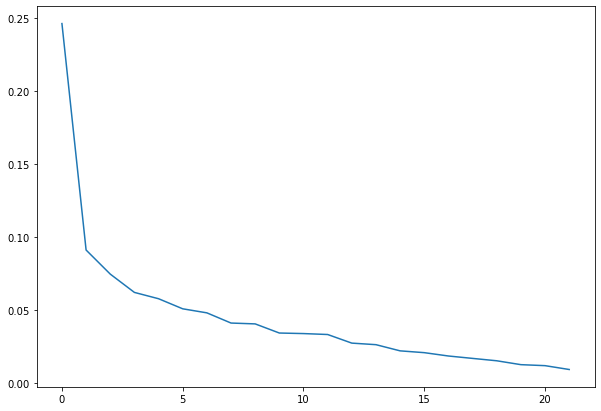

In [737]:
plt.figure(figsize = (10,7))
sns.lineplot(x=range(num_principal_components), y=cumulative_var)